In [1]:
import scipy.io
import numpy as np
import math
import os
import csv
import umap
from soundsig.sound import WavFile, BioSound

In [2]:
import sklearn.datasets
import pandas as pd
import numpy as np
import umap

In [3]:
# Accessor functions
def load_mat(filename):
    """
    This function should be called instead of scipy.io.loadmat
    as it can recover python dictionaries from mat files.
    """

    def _check_keys(d):
        """
        Checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        """
        for key in d:
            if isinstance(d[key], scipy.io.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        """
        A recursive function which constructs from matobjects nested dictionaries
        """
        nested_d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
                nested_d[strg] = _todict(elem)
            else:
                nested_d[strg] = elem
        return nested_d

    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)


def get_num_sections(data_file, logger_id):
    """
    Gets the number of sections in piezo LOGGER_ID from ndarray DATA_FILE.
    """
    return len(data_file[WAVE_KEY][logger_id])


def get_piezo_wave_at_section(data_file, logger_id, section):
    """
    Gets Piezo_wave of piezo LOGGER_ID from ndarray DATA_FILE at section SECTION.
    """
    return data_file[WAVE_KEY][logger_id][section]

def create_zip(paths, idx):
    data_buffer, label_buffer = [], []
    train_data_files, train_label_files = [], []
    test_data_files, test_label_files = [], []
    for path in paths:
        for file in os.listdir(path):
            if file.endswith("200.mat"):
                label_buffer.append(os.path.join(path, file))
        label_buffer = sorted(label_buffer)
        data_buffer = [e[:-8] + ".mat" for e in label_buffer]
        for e in data_buffer:
            if not os.path.exists(e):
                raise ValueError("file", e, "not found, but its label exists!")
        train_data_files.extend(data_buffer[:idx])
        test_data_files.extend(data_buffer[idx:])
        train_label_files.extend(label_buffer[:idx])
        test_label_files.extend(label_buffer[idx:])
        data_buffer, label_buffer = [], []
    train_zip = list(zip(train_data_files, train_label_files))
    test_zip = list(zip(test_data_files, test_label_files))
    return train_zip, test_zip

def process_files(files_zip, is_test):
    all_vocs = []
    all_noises = []
    for i in range(len(files_zip)):
        # Load files and their sample rates
        sample = files_zip[i]
        data_file = load_mat(sample[0])
        label_file = load_mat(sample[1])
        if START_KEY not in label_file:
            print("{0} doesn't have {1}. Skipping".format(sample[1], START_KEY))
            continue
        # Create two-way mapping between indices and logger ID's
        mapping = get_mapping(data_file)
        # Short name for saving to new format
        chars_to_keep = "0123456789_"
        short_name = ''.join(c for c in sample[0] if c in chars_to_keep)
        # Write to disk
        print("Generating", i, "out of", len(files_zip))
        mat_vocs, mat_noises = write_mat_entire(short_name, data_file, label_file, mapping, is_test)
        all_vocs.extend(mat_vocs)
        all_noises.extend(mat_noises)
    if is_test:
        vocs_csv = "test_vocs.csv"
        noises_csv = "test_noises.csv"
    else:
        vocs_csv = "train_vocs.csv"
        noises_csv = "train_noises.csv"
    with open(vocs_csv, 'w', newline='') as f:
        write = csv.writer(f)
        write.writerows(all_vocs)
    with open(noises_csv, 'w', newline='') as f:
        write = csv.writer(f)
        write.writerows(all_noises)

def open_files(paths):
    mat_objs = []
    for path in paths:
        for file in os.listdir(path):
            if file.endswith("200.mat"):
                mat_objs.append(load_mat(path + "/" + str(file)))
    return mat_objs

In [4]:
root = os.getcwd()
paths = [root + "/20190822", root + "/20190823"]
mat_objs = open_files(paths)
# print(len(mat_objs), mat_objs[0].keys(), mat_objs[1]['BioSoundCalls'])
flag = True

In [5]:
print(type(mat_objs))

<class 'list'>


In [7]:
collected_data = [row[0].spectro for mat_obj in mat_objs for row in mat_obj['BioSoundCalls']]
print(len(collected_data))

TypeError: 'mat_struct' object does not support indexing

In [6]:
def collect_data_spectrograms(mat_objs):
    collected_data = []
    for mat_obj in mat_objs:
        specs = mat_obj['BioSoundCalls']
        if len(specs) > 0 and not isinstance(specs[0], np.ndarray):
            specs = [specs]
        for row in specs:
            collected_data.append(row[0].spectro)
#         print(len(collected_data))
    funct = lambda mat: len(mat[0])
    min_time = len(min(collected_data, key = funct)[0])
#     print(min_time)
    vocalizations_data = []
    for mat in collected_data:
        start = len(mat[0]) // 2 - min_time // 2
        end = start + min_time
        vocalizations_data.append(mat[:, start:end].flatten())
    return np.vstack(vocalizations_data)

In [7]:
import re

def collect(mat_objs):
    collected_ids = []
    collected_data = []
    wf, wt = mat_objs[0]['BioSoundCalls'][0][0].wf, mat_objs[0]['BioSoundCalls'][0][0].wt
    w0 = next(x[0] for x in enumerate(wf) if x[1] > 0)
    w1 = next(x[0] for x in enumerate(wf) if x[1] > 0.0025)
    t0 = next(x[0] for x in enumerate(wt) if x[1] > -200)
    t1 = next(x[0] for x in enumerate(wt) if x[1] > 200)
    for mat_obj in mat_objs:
        if 'BioSoundFilenames' not in mat_obj.keys() or 'BioSoundCalls' not in mat_obj.keys():
            continue
        
        filenames = mat_obj['BioSoundFilenames']
        if len(filenames) > 0 and filenames.ndim == 1:
            filenames = [filenames]
        
        specs = mat_obj['BioSoundCalls']
        if len(specs) > 0 and not isinstance(specs[0], np.ndarray):
            specs = [specs]
        
        print(len(collected_data), len(collected_ids))
        for row_id, row in zip(filenames, specs):
            name = row_id[0]
            try:
                collected_data.append(row[0].mps[w0:w1, t0:t1].flatten())
                x = re.search("Bat\d*", name)
            except (TypeError, AttributeError):
                print(row)
                continue
            name = name[x.start() + 3:x.end()]
            if type(name) == str:
                collected_ids.append(name)
    print(len(collected_ids))
    y_set = set(collected_ids)
    hashed_y = {}
    for i, val in enumerate(y_set):
        hashed_y[val] = i
    hashed = lambda x: int(hashed_y[x])
    return np.array(list(y_set)), np.array(collected_ids), l2_norm(np.vstack(collected_data))

In [10]:
y_ids, y, voc_data = collect(mat_objs)
print(len(y))
print(voc_data.shape)

0 0
11 11
16 16
19 19
30 30
34 34
35 35
49 49
51 51
53 53
55 55
72 72
78 78
82 82
89 89
92 92
102 102
104 104
110 110
125 125
142 142
155 155
172 172
183 183
[array([], dtype=float64) array([], dtype=float64)]
[array([], dtype=float64) array([], dtype=float64)]
193 193
197 197
255 255
264 264
268 268
280 280
[array([], dtype=float64) array([], dtype=float64)]
308 308
315 315
323 323
343 343
359 359
367 367
397 397
407 407
414
[ 2.58202938  7.53181147 17.75552241 ...  0.9598544   2.09918396
  2.30638862]
[ 8.13196501 10.05223685 11.88757875 ...  2.18445817  1.89288088
  1.6133548 ]
414
(414, 5084)


In [11]:
y_set = set(y)
print(y_set)
hashed_y = {}
for i, val in enumerate(y_set):
    hashed_y[val] = i
print(hashed_y)

{'65706', '14647', '14644', '71284', '65704'}
{'65706': 0, '14647': 1, '14644': 2, '71284': 3, '65704': 4}


In [12]:
y = np.vectorize(hashed_y.get)(y)

In [9]:
def avged_norm(mats):
    print(mats[0])
    print(np.mean(mats, axis=0))
    return (mats - np.min(mats, axis=0)) / (np.max(mats, axis=0) - np.min(mats, axis=0))

In [8]:
def l2_norm(mats):
    print(mats[0])
    print(np.mean(mats, axis=0))
    return mats / np.linalg.norm(mats, axis=0)

In [13]:
def collect_data_mps(mat_objs):
    collected_data = []
    print(len(mat_objs))
    wf, wt = mat_objs[0]['BioSoundCalls'][0][0].wf, mat_objs[0]['BioSoundCalls'][0][0].wt
    w0 = next(x[0] for x in enumerate(wf) if x[1] > 0)
    w1 = next(x[0] for x in enumerate(wf) if x[1] > 0.0025)
    t0 = next(x[0] for x in enumerate(wt) if x[1] > -200)
    t1 = next(x[0] for x in enumerate(wt) if x[1] > 200)
    print(w0, w1, t0, t1)
    for mat_obj in mat_objs:
        if 'BioSoundCalls' not in mat_obj.keys():
            continue
        print(len(collected_data))
        specs = mat_obj['BioSoundCalls']
        if len(specs) > 0 and not isinstance(specs[0], np.ndarray):
            specs = [specs]
        for row in specs:
            try:
                collected_data.append(row[0].mps[w0:w1, t0:t1].flatten())
            except AttributeError:
                print(row)
#     vocalizations_data = []
#     for mat in collected_data:
#         start = len(mat[0]) // 2 - interval // 2
#         end = start + interval
#         vocalizations_data.append(mat[:, start:end].flatten())
    return l2_norm(np.vstack(collected_data))

In [15]:
voc_data = collect_data(mat_objs)
print(voc_data.shape)

NameError: name 'collect_data' is not defined

In [14]:
voc_data_mps = collect_data_mps(mat_objs)
print(voc_data_mps.shape)

39
244 368 30 71
0
11
16
19
30
34
35
49
51
53
55
72
78
82
89
92
102
104
110
125
142
155
172
183
[array([], dtype=float64) array([], dtype=float64)]
[array([], dtype=float64) array([], dtype=float64)]
193
197
255
264
268
280
[array([], dtype=float64) array([], dtype=float64)]
308
315
323
343
359
367
397
407
[ 2.58202938  7.53181147 17.75552241 ...  0.9598544   2.09918396
  2.30638862]
[ 8.13196501 10.05223685 11.88757875 ...  2.18445817  1.89288088
  1.6133548 ]
(414, 5084)


In [15]:
print(voc_data[0])

[0.0123871  0.02842835 0.05621996 ... 0.01534275 0.0393911  0.04998729]


In [336]:
%matplotlib notebook
import matplotlib.pyplot as plt

def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(voc_data);
    embedding_mps = reducer_mps.transform(voc_data)
    assert(np.all(embedding_mps == reducer_mps.embedding_))
    print(embedding_mps.shape)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=y)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=y)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=y, s=100)
    title = "umap for n_neighbors = " + str(n_neighbors) + " and min_dist = " + str(min_dist) + " and n_components = " + str(n_components)
    plt.title(title, fontsize=18)
    plt.show()

In [17]:
def draw_umap(n_neighbors=10, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(voc_data);
    print(u)
    
draw_umap()

[[ 6.287561   8.055807 ]
 [ 5.6334677  6.8014827]
 [ 1.9389195  5.73188  ]
 [ 9.089926   8.341388 ]
 [ 7.56528    7.7925887]
 [ 8.152174   8.255944 ]
 [ 7.355717   8.026057 ]
 [ 5.9819474  7.681342 ]
 [ 6.4966435  7.4306726]
 [ 5.7626195  5.9401445]
 [ 3.495772   4.7121415]
 [ 8.713522   8.406131 ]
 [ 5.2436996  8.234774 ]
 [ 7.702378   7.532829 ]
 [ 3.0131075  6.3607016]
 [ 3.4872043  4.8705134]
 [ 1.2917713  5.277637 ]
 [ 1.4435133  5.2154765]
 [ 5.965264   7.0097823]
 [ 5.078636   7.525898 ]
 [ 3.4024951  5.062016 ]
 [ 4.106964   5.4514318]
 [ 4.1112046  6.2012205]
 [ 2.440301   6.0945816]
 [ 2.1605077  5.2607517]
 [ 4.9604     5.365066 ]
 [ 7.858226   7.7196393]
 [ 5.3193045  7.908294 ]
 [ 6.5269628  7.7531686]
 [ 7.376953   7.826732 ]
 [ 6.057792   6.7056913]
 [ 3.8884275  5.662771 ]
 [ 6.5958333  6.903789 ]
 [ 9.480541   7.455287 ]
 [ 8.147843   7.316817 ]
 [ 3.6618853  5.506609 ]
 [ 3.6180763  5.2665143]
 [ 4.363887   7.171592 ]
 [ 5.15249    7.477478 ]
 [ 3.7168026  6.333028 ]


(414, 2)


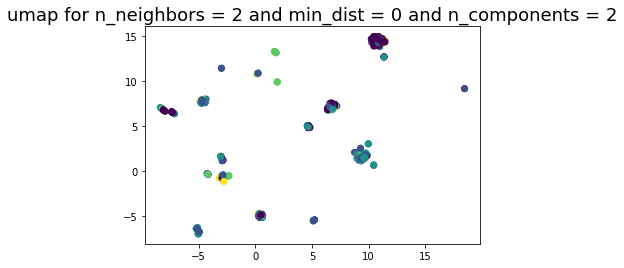

(414, 2)


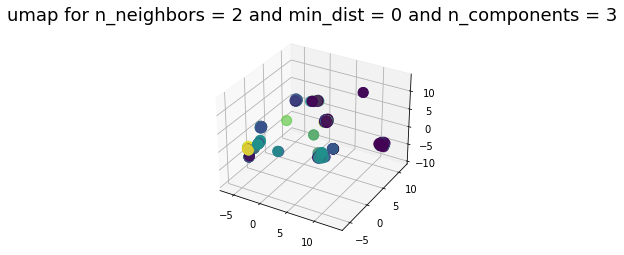

(414, 2)


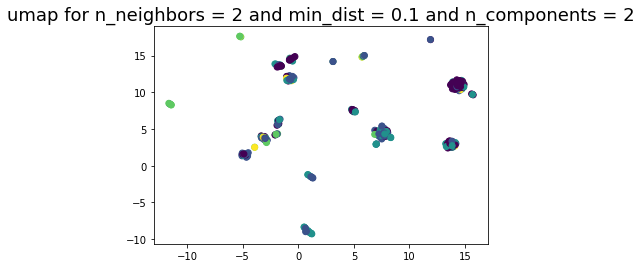

(414, 2)


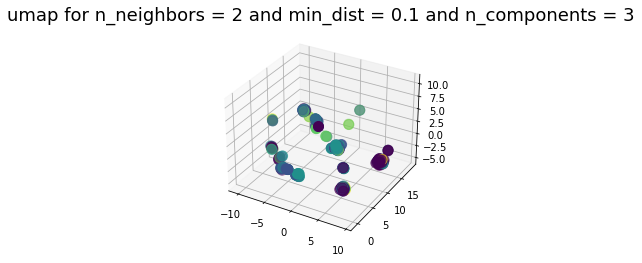

(414, 2)


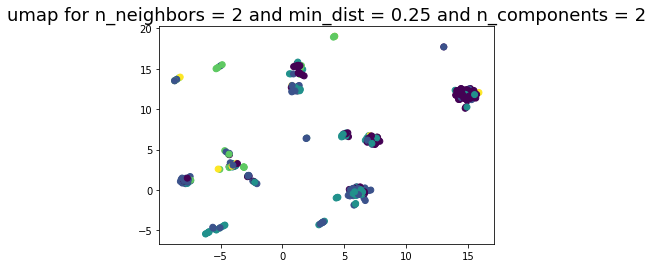

(414, 2)


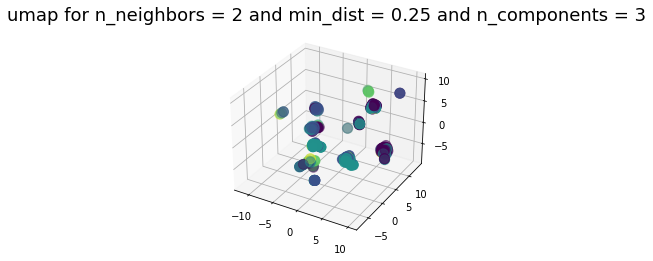

(414, 2)


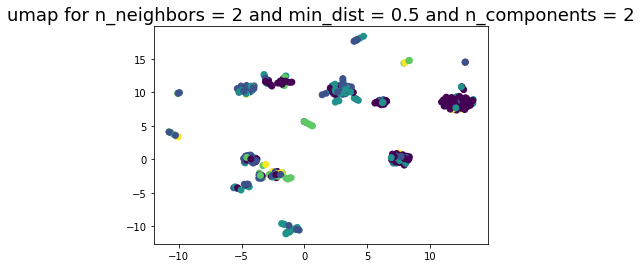

(414, 2)


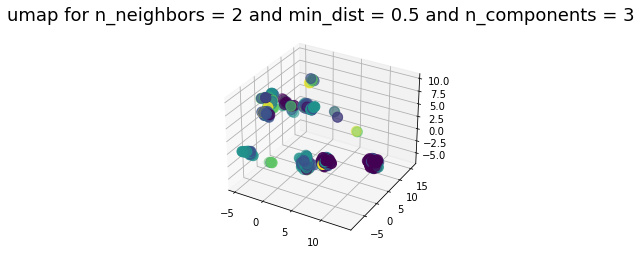

(414, 2)


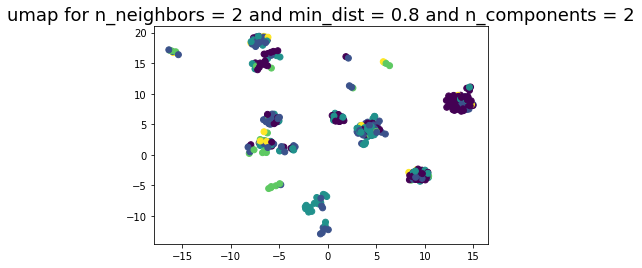

(414, 2)


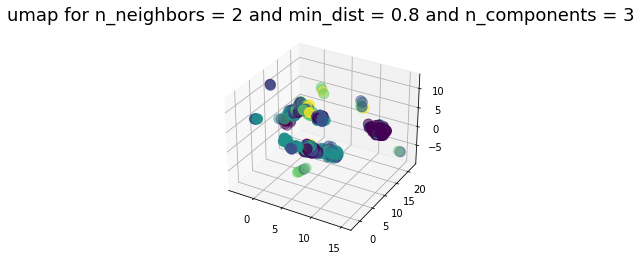

(414, 2)


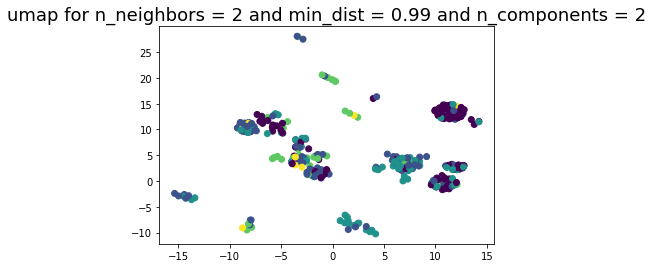

(414, 2)


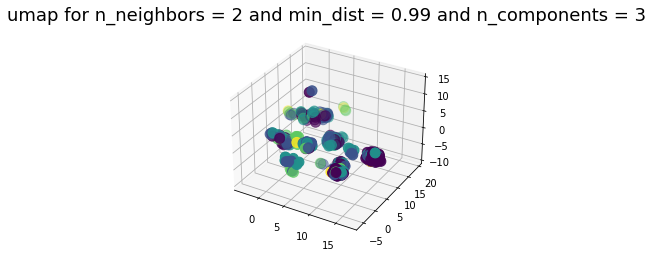

(414, 2)


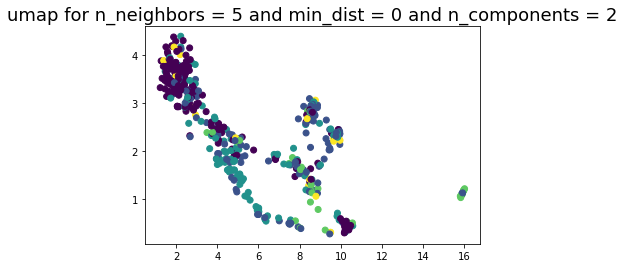

(414, 2)


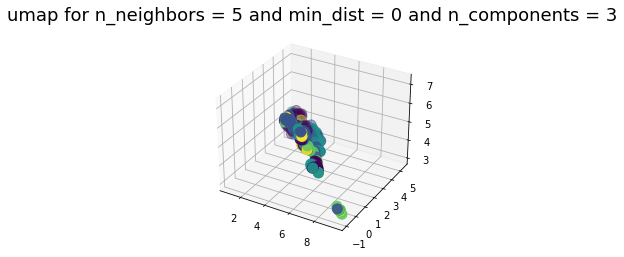

(414, 2)


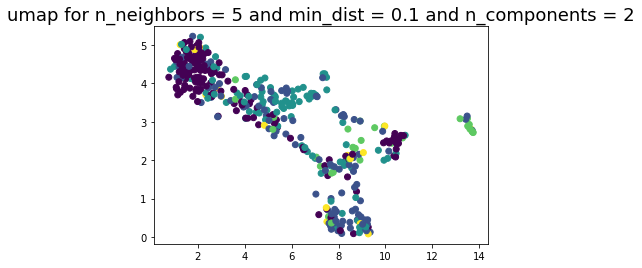

(414, 2)


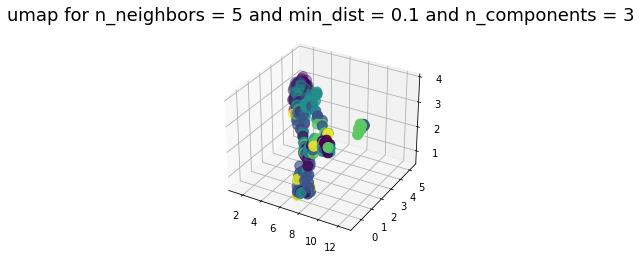

(414, 2)


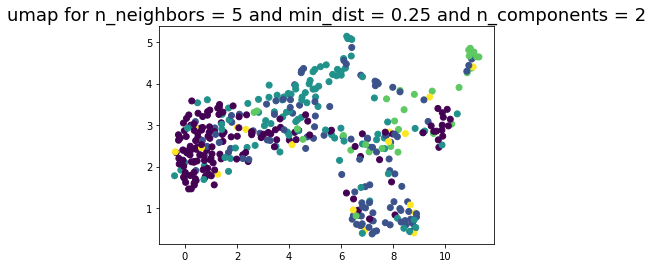

(414, 2)


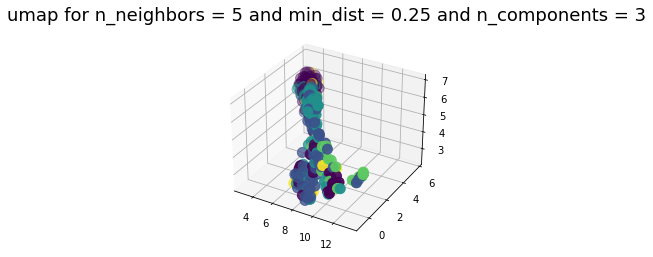

(414, 2)


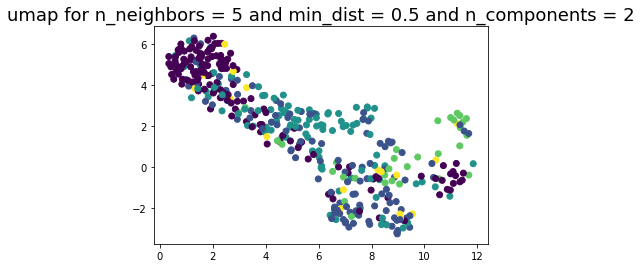

(414, 2)


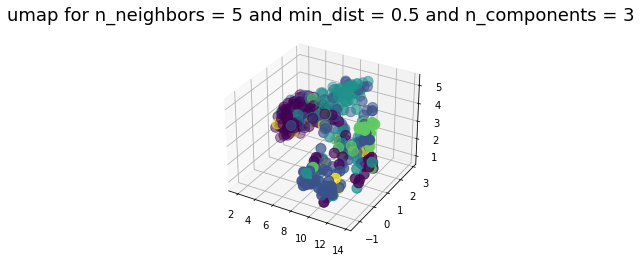

(414, 2)


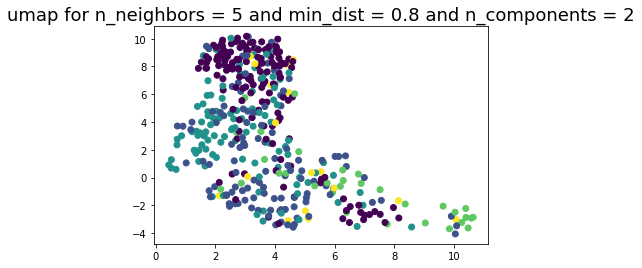

(414, 2)


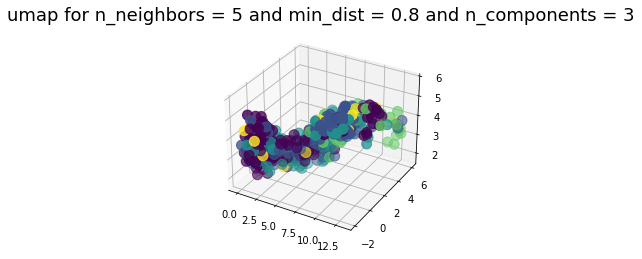

(414, 2)


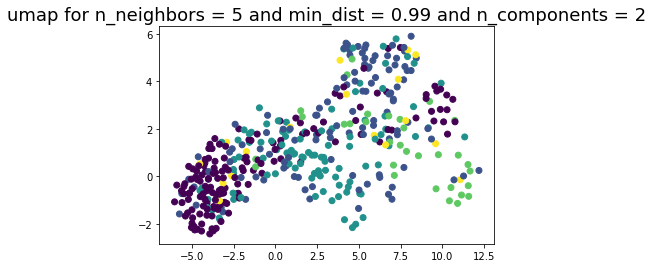

(414, 2)


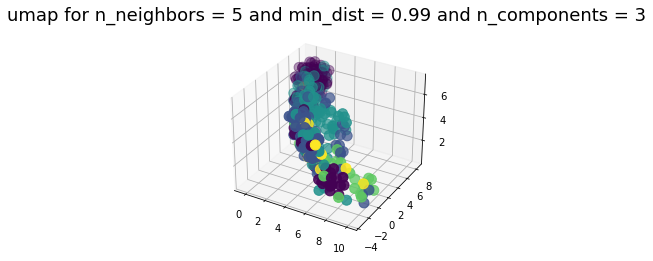

(414, 2)


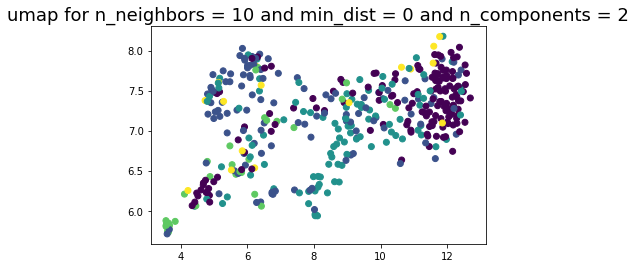

(414, 2)


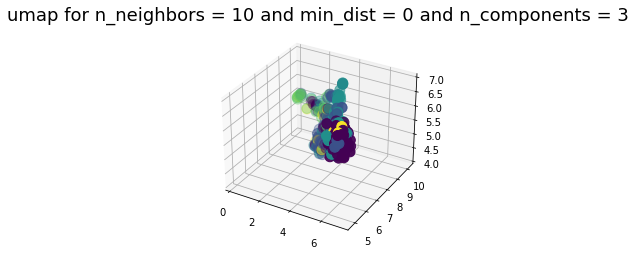

(414, 2)


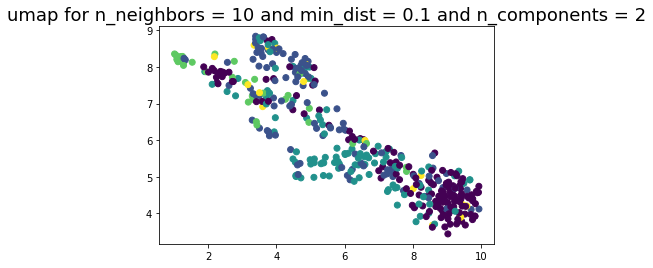

(414, 2)


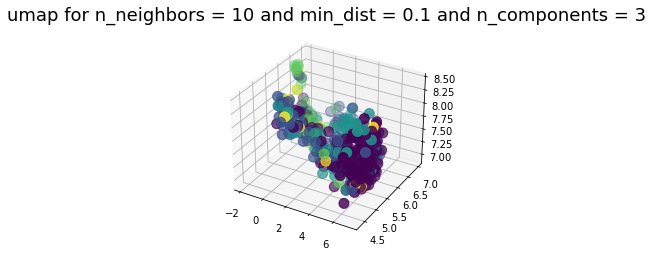

(414, 2)


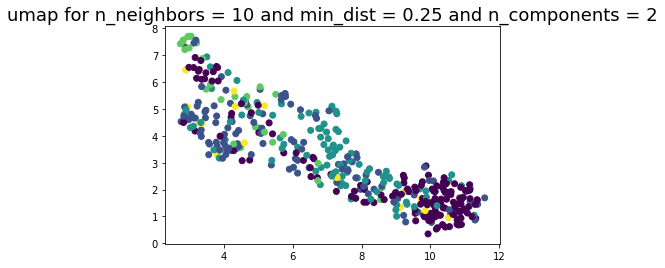

(414, 2)


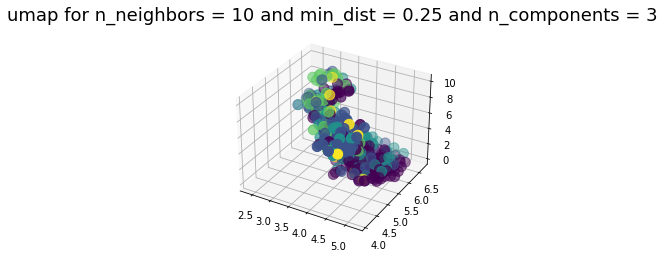

(414, 2)


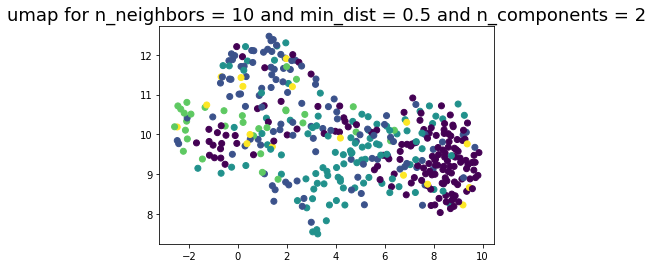

(414, 2)


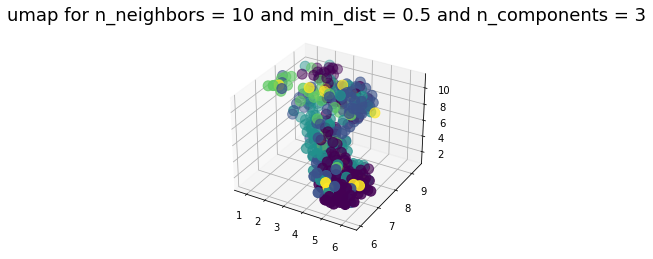

(414, 2)


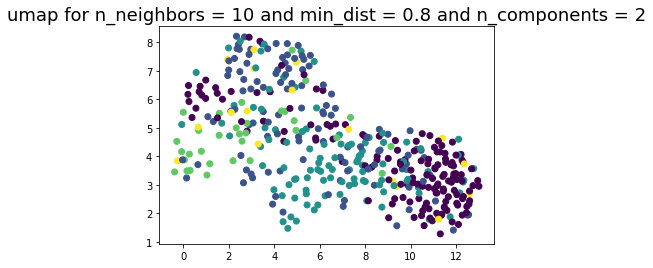

(414, 2)


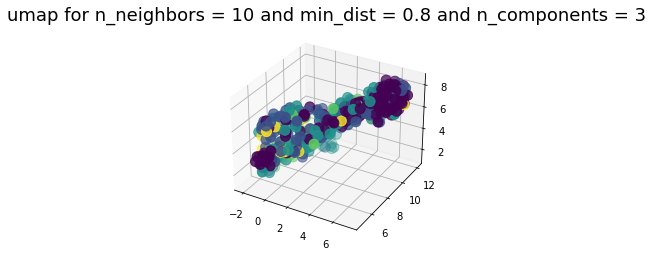

(414, 2)


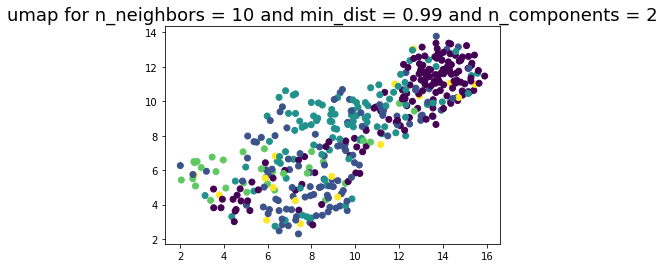

(414, 2)


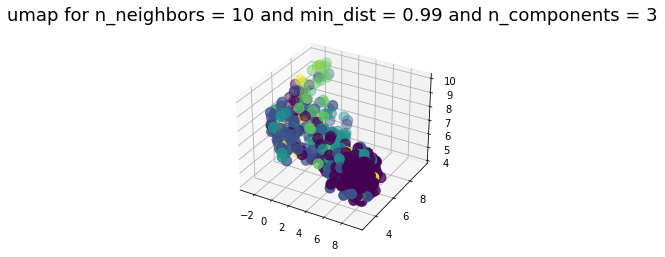

(414, 2)


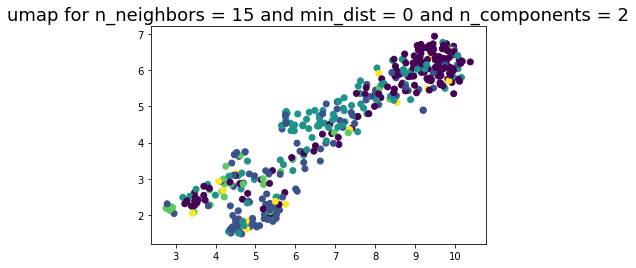

(414, 2)


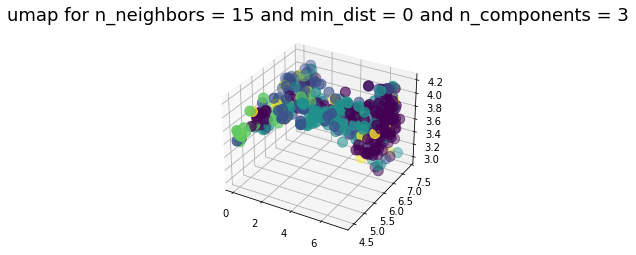

(414, 2)


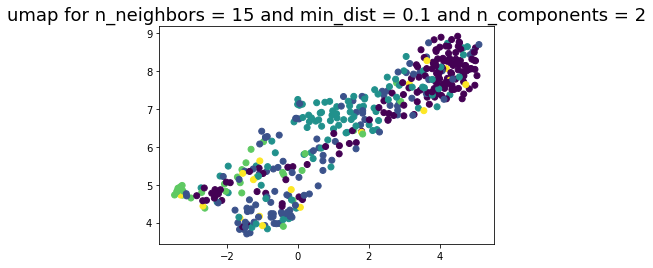

(414, 2)


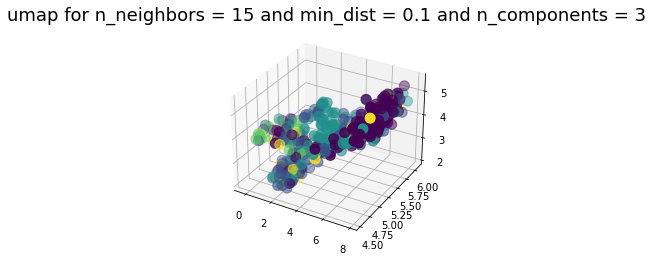

(414, 2)


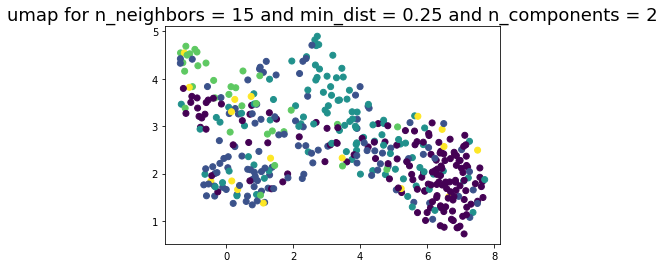

(414, 2)


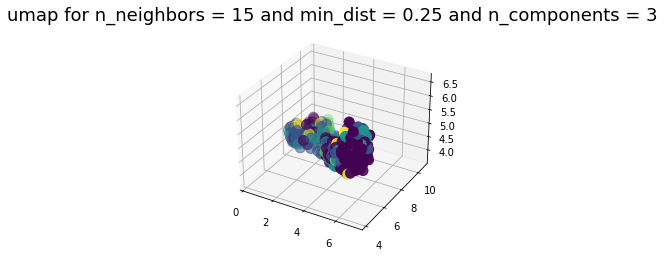

(414, 2)


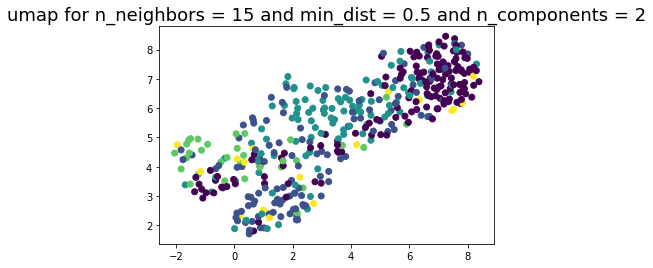

(414, 2)


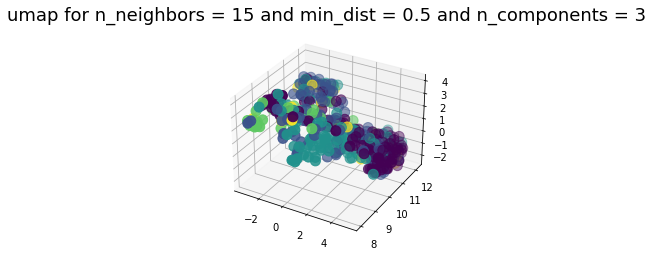

(414, 2)


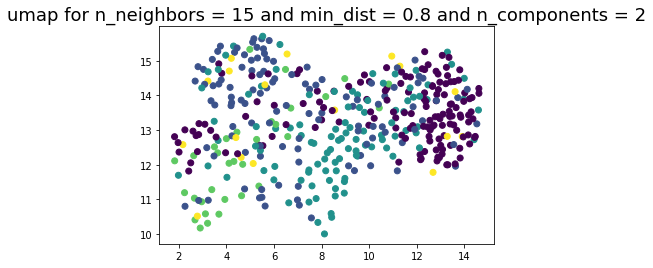

(414, 2)


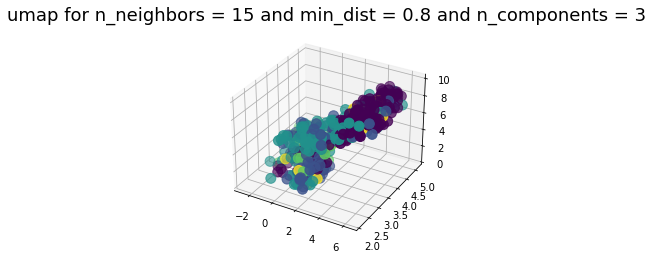

(414, 2)


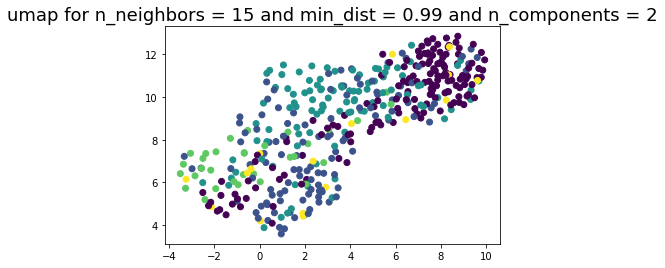

(414, 2)


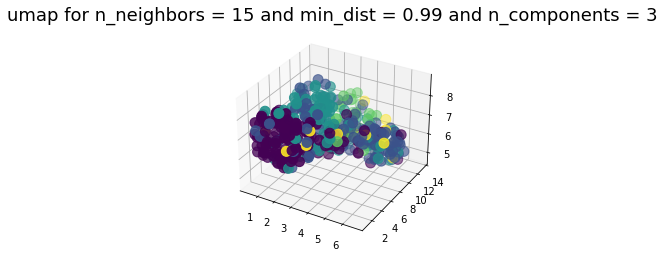

(414, 2)


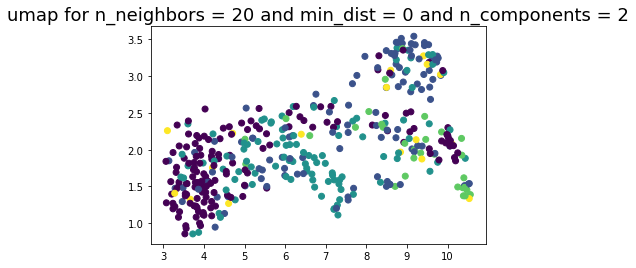

(414, 2)


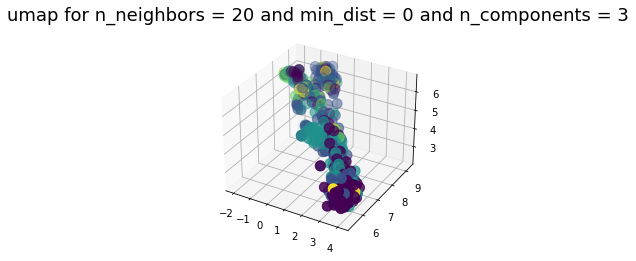

(414, 2)


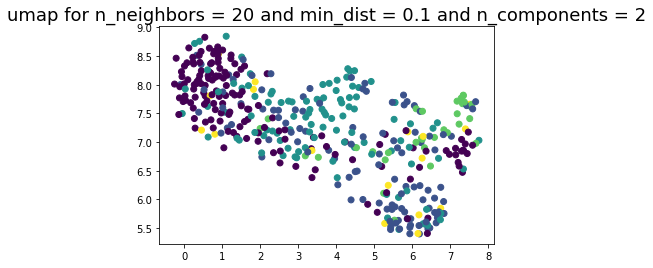

(414, 2)


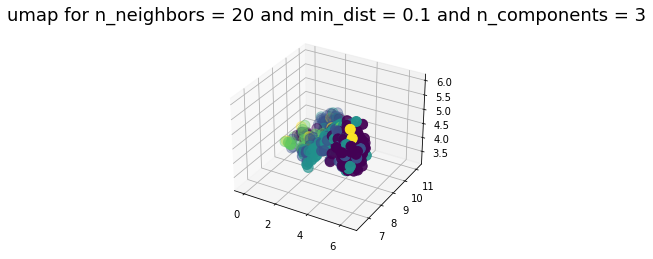

(414, 2)


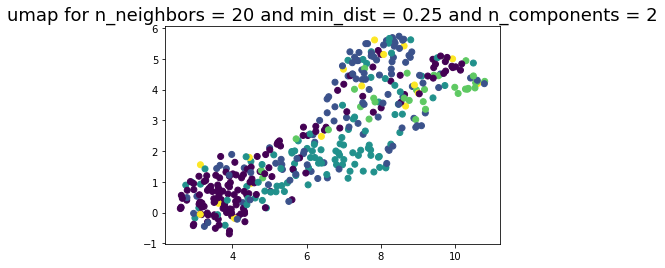

(414, 2)


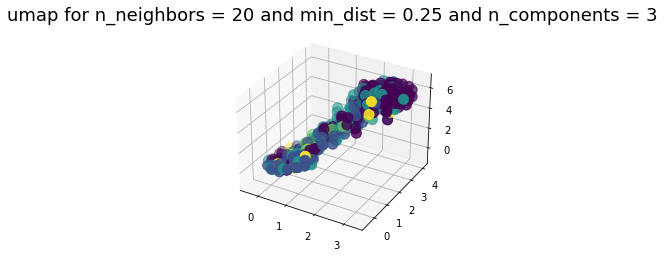

(414, 2)


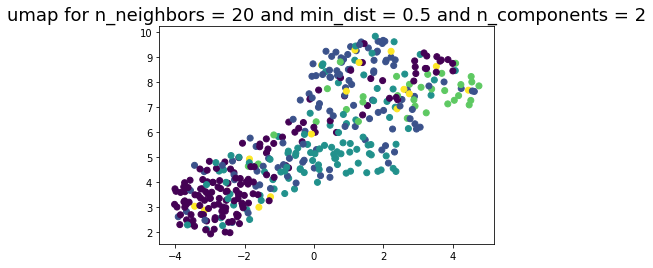

(414, 2)


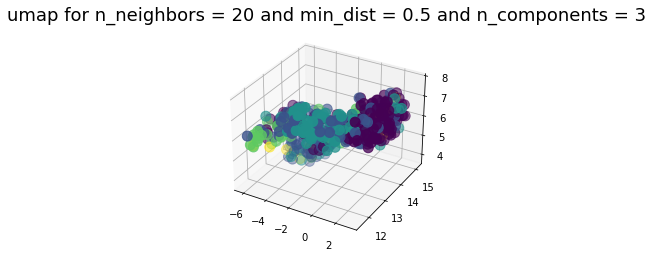

(414, 2)


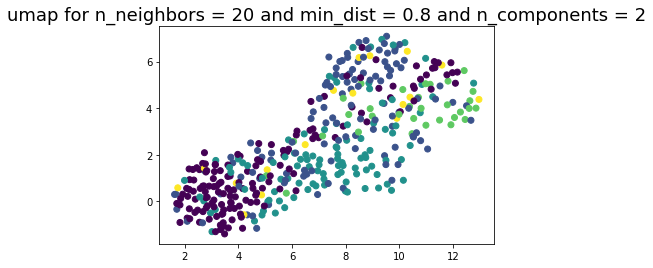

(414, 2)


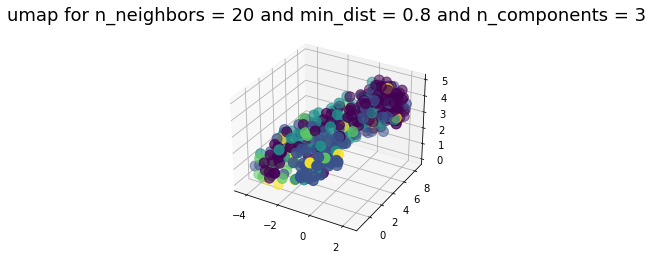

(414, 2)


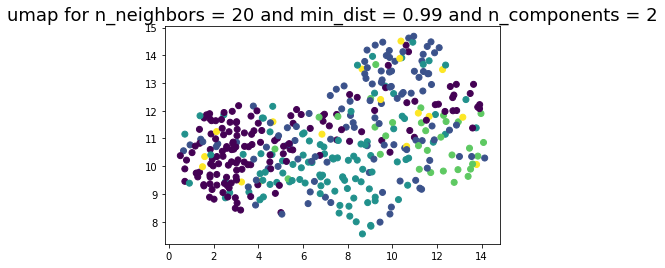

(414, 2)


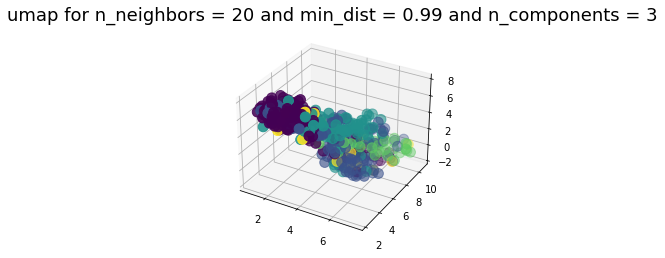

(414, 2)


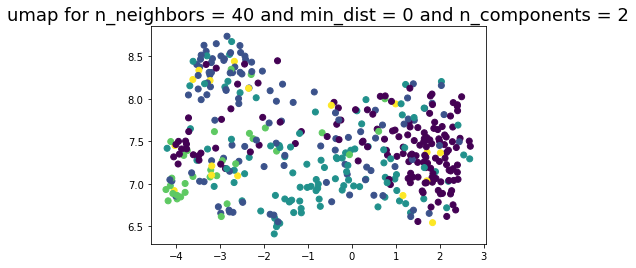

(414, 2)


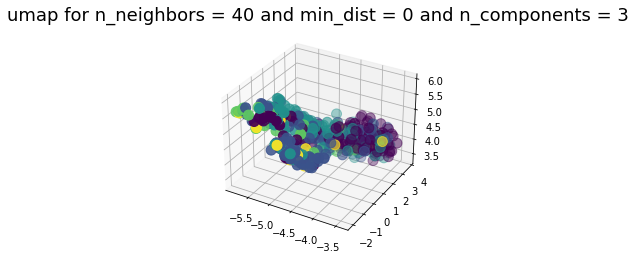

(414, 2)


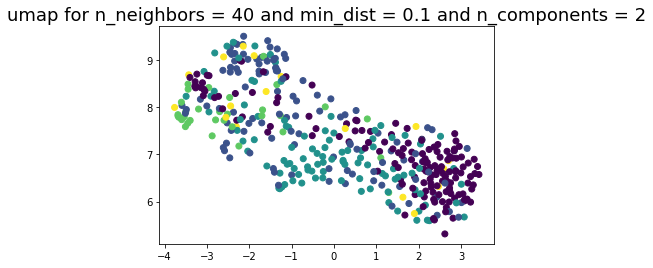

(414, 2)


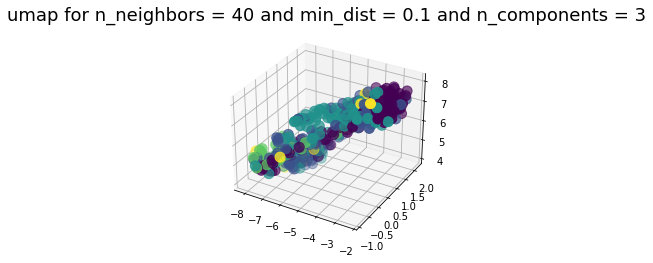

(414, 2)


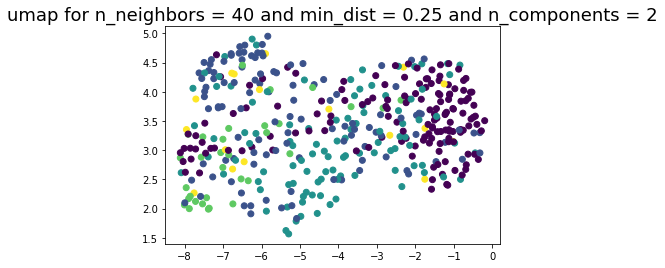

(414, 2)


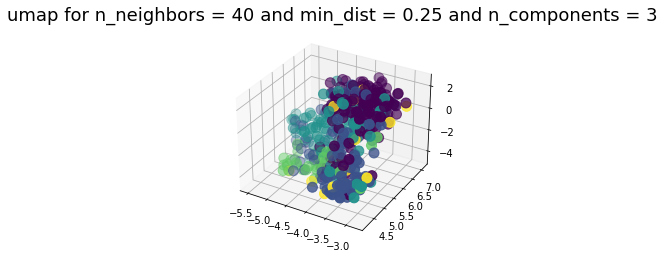

(414, 2)


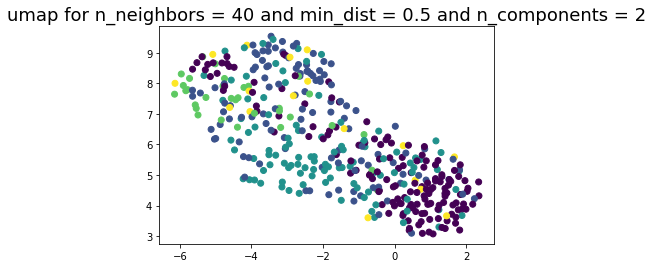

(414, 2)


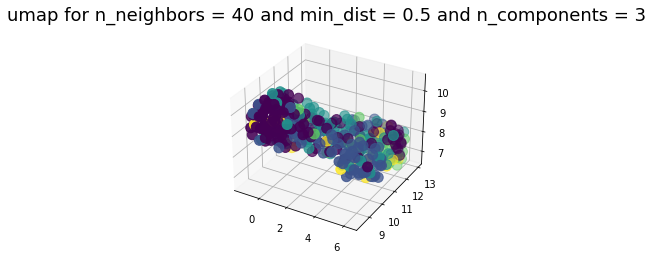

(414, 2)


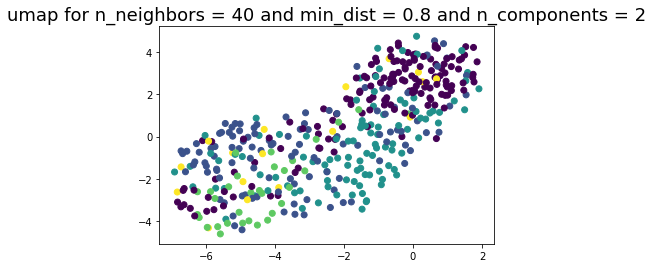

(414, 2)


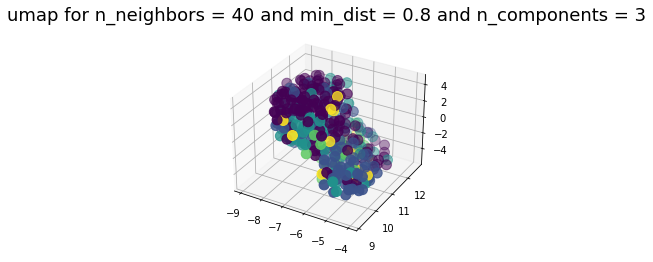

(414, 2)


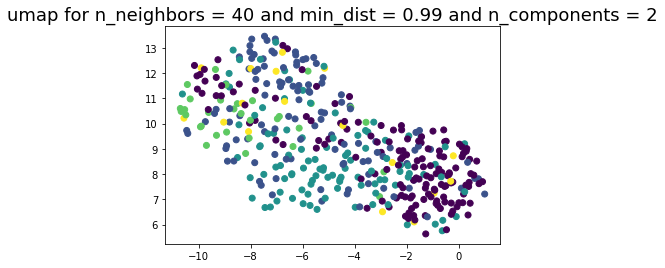

(414, 2)


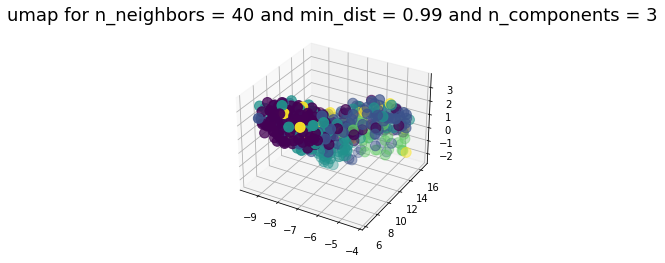

(414, 2)


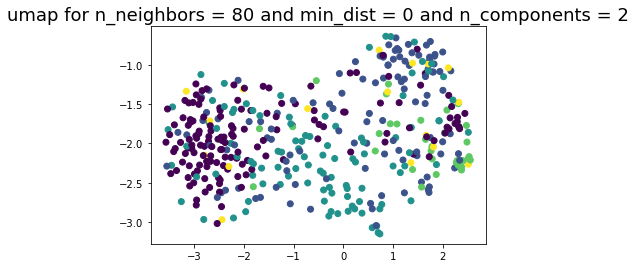

(414, 2)


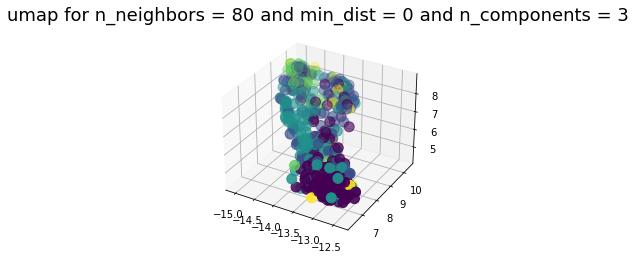

(414, 2)


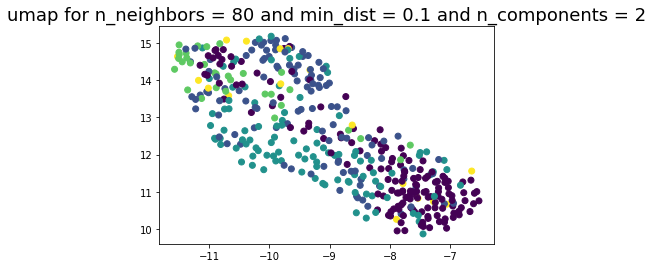

(414, 2)


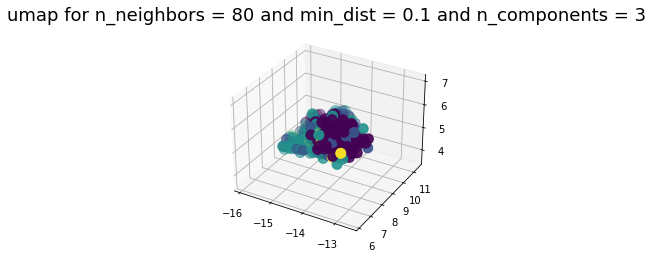

(414, 2)


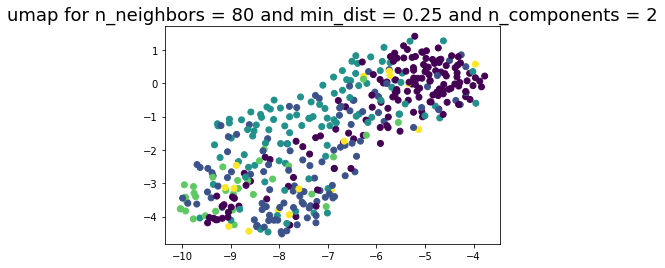

(414, 2)


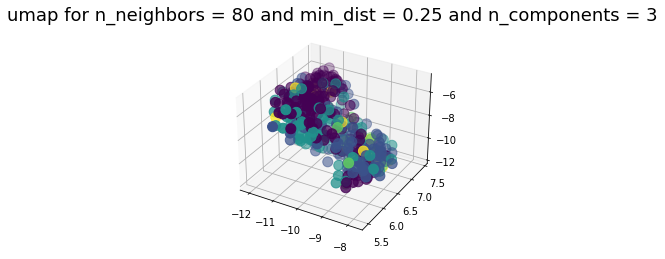

(414, 2)


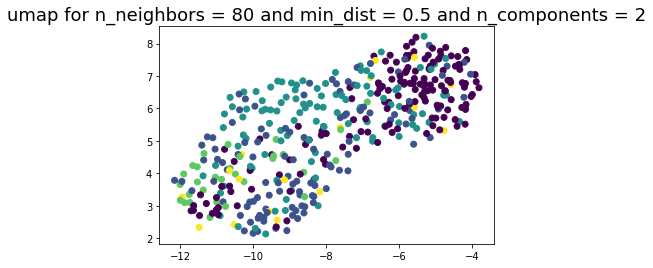

(414, 2)


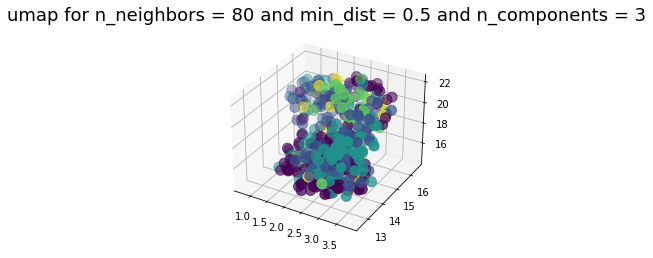

(414, 2)


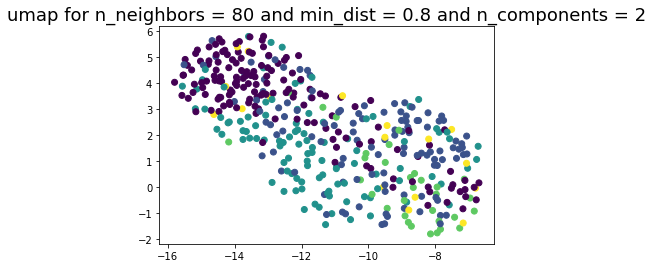

(414, 2)


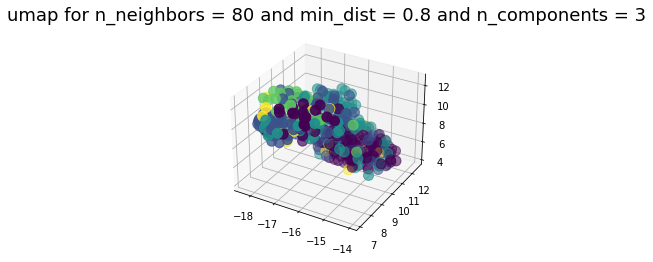

(414, 2)


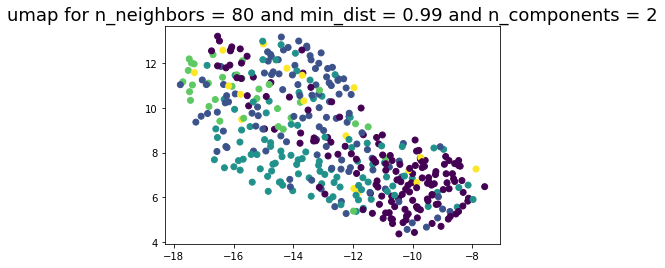

(414, 2)


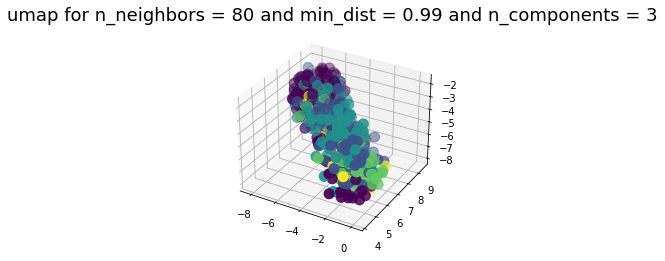

In [66]:
for n_neighbor in [2, 5, 10, 15, 20, 40, 80]:
    for min_dist in [0, 0.1, 0.25, 0.5, 0.8, 0.99]:
        for n_component in [2, 3]:
            draw_umap(n_neighbor, min_dist, n_component)

In [19]:
import umap.plot
from bokeh.models import Button
from bokeh.io import curdoc

In [20]:
hover_data = pd.DataFrame({'index':np.arange(414),
                           'label':y})
hover_data['batID'] = hover_data.label.map(
    {0: '14644', 1: '71284', 2: '14647', 3: '65704', 4: '65706'}
)

In [21]:
iph = hover_data.to_dict()
dict_idx = list(iph['index'].values())
iph['index'] = dict_idx
dict_lbl = list(iph['label'].values())
iph['label'] = dict_lbl
dict_batID = list(iph['batID'].values())
iph['batID'] = dict_batID

In [22]:
iph_pd = pd.DataFrame.from_dict(iph)

In [23]:
print(iph_pd[['index', 'label', 'batID']])

     index  label  batID
0        0      1  71284
1        1      1  71284
2        2      1  71284
3        3      1  71284
4        4      1  71284
..     ...    ...    ...
409    409      1  71284
410    410      2  14647
411    411      3  65704
412    412      1  71284
413    413      0  14644

[414 rows x 3 columns]


In [298]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from soundsig.signal import bandpass_filter
from soundsig.sound import spectrogram, plot_spectrogram, log_transform, play_sound_array

In [24]:
def collect_bioSound_objs():    
    collected_data = []
    print(len(mat_objs))
    for mat_obj in mat_objs:
        if 'BioSoundCalls' not in mat_obj.keys():
            continue
        print(len(collected_data))
        specs = mat_obj['BioSoundCalls']
        if len(specs) > 0 and not isinstance(specs[0], np.ndarray):
            specs = [specs]
        for row in specs:
            if row[0] != [] and 'mps' in row[0]._fieldnames:
                collected_data.append(row[0])
            else:
                print(row)
#     vocalizations_data = []
#     for mat in collected_data:
#         start = len(mat[0]) // 2 - interval // 2
#         end = start + interval
#         vocalizations_data.append(mat[:, start:end].flatten())
    return collected_data
        

39
0
11
16
19
30
34
35
49
51
53
55
72
78
82
89
92
102
104
110
125
142
155
172
183
[array([], dtype=float64) array([], dtype=float64)]
[array([], dtype=float64) array([], dtype=float64)]
193
197
255
264
268
280
[array([], dtype=float64) array([], dtype=float64)]
308
315
323
343
359
367
397
407


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if sys.path[0] == '':


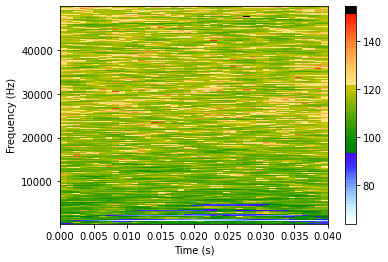

In [27]:
bioSound_objs_list = collect_bioSound_objs()
# print(bioSound_objs_list[0].spectro)

# min_db = np.max(bioSound_objs_list[0].spectro) - 50

# print(min_db, bioSound_objs_list[0].fo)

plot_spectrogram(bioSound_objs_list[0].to, bioSound_objs_list[0].fo, bioSound_objs_list[0].spectro, log=False, dBNoise=None)

In [29]:
plot_spectrogram(bioSound_objs_list[64].to, bioSound_objs_list[64].fo, spectro, dBNoise = 60)

NameError: name 'spectro' is not defined

In [366]:
%matplotlib inline
import colorsys
import matplotlib.colors as pltcolors
from IPython.display import clear_output
import plotly.graph_objects as go

In [367]:
from ipywidgets import Output

In [368]:
def spec_colormap():
# Makes the colormap that we like for spectrograms

    cmap = np.zeros((64,3))
    cmap[0,2] = 1.0

    for ib in range(21):
        cmap[ib+1,0] = (31.0+ib*(12.0/20.0))/60.0
        cmap[ib+1,1] = (ib+1.0)/21.0
        cmap[ib+1,2] = 1.0

    for ig in range(21):
        cmap[ig+ib+1,0] = (21.0-(ig)*(12.0/20.0))/60.0
        cmap[ig+ib+1,1] = 1.0
        cmap[ig+ib+1,2] = 0.5+(ig)*(0.3/20.0)

    for ir in range(21):
        cmap[ir+ig+ib+1,0] = (8.0-(ir)*(7.0/20.0))/60.0
        cmap[ir+ig+ib+1,1] = 0.5 + (ir)*(0.5/20.0)
        cmap[ir+ig+ib+1,2] = 1

    for ic in range(64):
        (cmap[ic,0], cmap[ic,1], cmap[ic,2]) = colorsys.hsv_to_rgb(cmap[ic,0], cmap[ic,1], cmap[ic,2])
    
    spec_cmap = pltcolors.ListedColormap(cmap, name=u'SpectroColorMap', N=64)
    plt.register_cmap(cmap=spec_cmap)

def plot_spectro(t, freq, spec, ax=None, ticks=True, fmin=None, fmax=None, colormap=None, colorbar=True, log = True, dBNoise = 50):
            if colormap == None:
                spec_colormap()
                colormap = plt.get_cmap('SpectroColorMap')

            if ax is None:
                ax = plt.gca()

            if fmin is None:
                fmin = freq.min()
            if fmax is None:
                fmax = freq.max()

            ex = (t.min(), t.max(), freq.min(), freq.max())
            plotSpect = np.abs(spec)


            if log == True and dBNoise is not None:
                plotSpect = 20*np.log10(plotSpect)
                maxB = plotSpect.max()
                minB = maxB-dBNoise
            else:
                if dBNoise is not None:
                    maxB = 20*np.log10(plotSpect.max())
                    minB = ((maxB-dBNoise)/20.0)**10
                else:
                    maxB = plotSpect.max()
                    minB = plotSpect.min()

            plotSpect[plotSpect < minB] = minB

            return ax, ex, colormap, minB, maxB, plotSpect, fmin, fmax, ticks, colorbar
        
def plot_spectrom(ind, ax=None):
    spectro = bioSound_objs_list[ind].spectro/20
    spectro = 10**(spectro)
    return plot_spectro(bioSound_objs_list[ind].to, bioSound_objs_list[ind].fo, spectro, ax=ax, dBNoise=60)

In [377]:
def interactive_plot(n_neighbors=10, min_dist=0.1, n_components=2, metric='euclidean', title='', ax=None):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(voc_data);

    f = go.FigureWidget([go.Scatter(
        x=u[:,0], 
        y=u[:,1], 
        mode='markers',
        customdata=iph_pd[['index', 'label', 'batID']],
        hovertemplate = "<br>".join(["index: %{customdata[0]}", 
                                     "label: %{customdata[1]}",
                                     "batID: %{customdata[2]}<extra></extra>"])
    )])
    scatter = f.data[0]
    scatter.marker.color = y
#     print(len(y), y)
    f.layout.hovermode = 'closest'
#     Audio(bioSound_objs_list[0].sound, rate=bioSound_objs_list[0].samprate, autoplay=True)
    plt.ion()
    ax = None
    iax = None
    out = Output()
    display(out)
    
    def update_point(trace, points, selector):
        nonlocal ax
        nonlocal iax
        nonlocal out
#         c = list(scatter.marker.color)
#         s = list(scatter.marker.size)
#         print(c, s, len(c))
        for i in points.point_inds:
            if iax != None:
                with out:
                    clear_output(wait=True)
            if ax == None:
                ax, ex, colormap, minB, maxB, plotSpect, fmin, fmax, ticks, colorbar = plot_spectrom(i, ax)
                with out:
                    iax = ax.imshow(plotSpect, aspect='auto', interpolation='nearest', origin='lower', extent=ex, cmap=colormap, vmin=minB, vmax=maxB)
                    ax.set_ylim(fmin, fmax)
                    if not ticks:
                        ax.set_xticks([])
                        ax.set_yticks([])
                    else:
                        ax.set_ylabel('Frequency (Hz)')
                        ax.set_xlabel('Time (s)')

                    if colorbar:
                        plt.colorbar(iax)
            else:
                ax, ex, colormap, minB, maxB, plotSpect, fmin, fmax, ticks, colorbar = plot_spectrom(i, ax)
                with out:
                    iax = ax.imshow(plotSpect, aspect='auto', interpolation='nearest', origin='lower', extent=ex, cmap=colormap, vmin=minB, vmax=maxB)
                    plt.sca(ax)
                    plt.show()
            play_audio(i)
#             c[i] = '#bae2be' 
#             s[i] = 20
#             with f.batch_update():
#                 scatter.marker.color = c
#                 scatter.marker.size = s
    scatter.on_click(update_point)
    
    return f


In [375]:
def play_audio(index):
#      sound > 100 --> pad zeros (np.pad)
    sound = bioSound_objs_list[index].sound - np.mean(bioSound_objs_list[index].sound)
    sound = sound / np.std(bioSound_objs_list[index].sound)
    display(Audio(sound, rate=bioSound_objs_list[index].samprate, autoplay=True))

In [376]:
play_audio(74)

In [343]:
play_sound_array(bioSound_objs_list[0].sound, bioSound_objs_list[0].samprate)

Output()

FigureWidget({
    'data': [{'customdata': array([[0, 1, '71284'],
                                   [1, 1, '…

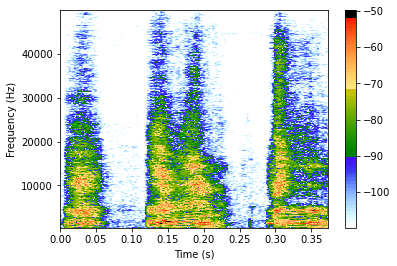

In [378]:
f = interactive_plot()
f


In [25]:
import plotly.graph_objects as go

import numpy as np
np.random.seed(1)

x = np.random.rand(100)
y = np.random.rand(100)

f = go.FigureWidget([go.Scatter(x=x, y=y, mode='markers')])

scatter = f.data[0]
colors = ['#a3a7e4'] * 100
scatter.marker.color = colors
scatter.marker.size = [10] * 100
f.layout.hovermode = 'closest'


# create our callback function
def update_point(trace, points, selector):
    c = list(scatter.marker.color)
    s = list(scatter.marker.size)
    print(c, s, len(c))
    for i in points.point_inds:
        print(i)
        c[i] = '#bae2be'
        s[i] = 20
        with f.batch_update():
            scatter.marker.color = c
            scatter.marker.size = s


scatter.on_click(update_point)

f

FigureWidget({
    'data': [{'marker': {'color': [#a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
               …

['#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4', '#a3a7e4'

In [54]:
umap.plot.output_notebook()

Loading BokehJS ...

In [26]:
import umap
def make_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    u = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    ).fit(voc_data)
    return u

In [27]:
mapper = make_umap(10, 0.1)

In [57]:
p = umap.plot.interactive(mapper, labels=y, hover_data=hover_data, point_size=10)


umap.plot.show(p)

In [56]:
reducer_mps = umap.UMAP(n_neighbors=10, min_dist=0.1)

In [57]:
reducer_mps.fit(voc_data)
embedding_mps = reducer_mps.transform(voc_data)
assert(np.all(embedding_mps == reducer_mps.embedding_))
print(embedding_mps.shape)

(414, 2)


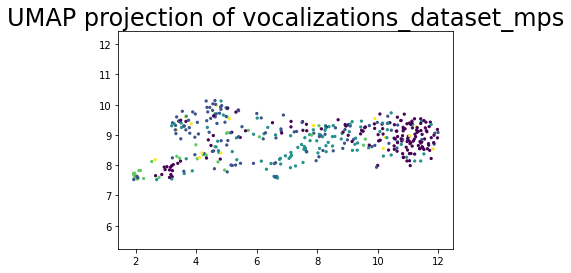

In [58]:
import matplotlib.pyplot as plt
plt.scatter(embedding_mps[:, 0], embedding_mps[:, 1], c=y, s=5)
plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of vocalizations_dataset_mps', fontsize=24);

In [272]:
from sklearn.datasets import load_digits

data_digits = load_digits()
print(data_digits.target)

[0 1 2 ... 8 9 8]


In [245]:
from IPython.display import Audio
from scipy.io.wavfile import *

In [246]:
b = read(root + "/Legend of Nezha Opening.wav")

In [247]:
b

(44100,
 array([[  0,   0],
        [  0,   0],
        [  0,   0],
        ...,
        [164, 164],
        [135, 135],
        [ -3,  -3]], dtype=int16))

In [255]:
# 96kHz, 50kHz
# Audio(b[1], b[0])
Audio(bioSound_objs_list[102].sound, rate=192000, autoplay=True)

(2898, 19440)
(2898, 2)


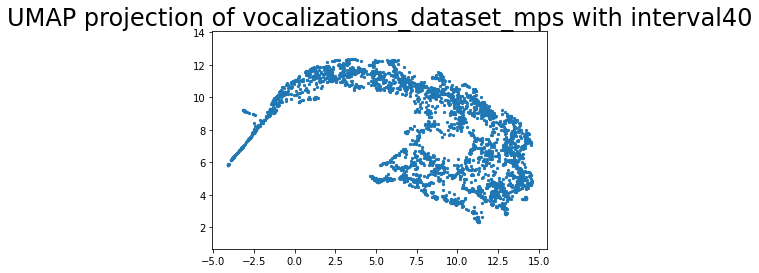

In [163]:
voc_data_mps = collect_data_mps(mat_objs, 40)
print(voc_data_mps.shape)
reducer_mps3 = umap.UMAP()
reducer_mps3.fit(voc_data_mps)
embedding_mps3 = reducer_mps3.transform(voc_data_mps)
assert(np.all(embedding_mps3 == reducer_mps3.embedding_))
print(embedding_mps2.shape)
# import matplotlib.pyplot as plt
plt.figure()
plt.scatter(embedding_mps3[:, 0], embedding_mps3[:, 1], s=5)
plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of vocalizations_dataset_mps with interval' + str(40), fontsize=24);
plt.show()

(2898, 29160)
(2898, 2)


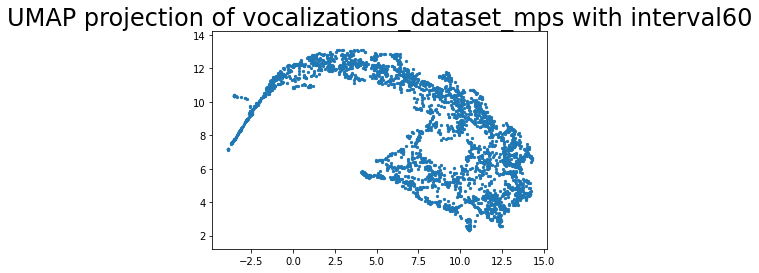

In [164]:
voc_data_mps = collect_data_mps(mat_objs, 60)
print(voc_data_mps.shape)
reducer_mps4 = umap.UMAP()
reducer_mps4.fit(voc_data_mps)
embedding_mps4 = reducer_mps4.transform(voc_data_mps)
assert(np.all(embedding_mps4 == reducer_mps4.embedding_))
print(embedding_mps4.shape)
# import matplotlib.pyplot as plt
plt.figure()
plt.scatter(embedding_mps4[:, 0], embedding_mps4[:, 1], s=5)
plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of vocalizations_dataset_mps with interval' + str(60), fontsize=24);
plt.show()

(2898, 9720)
(2898, 2)


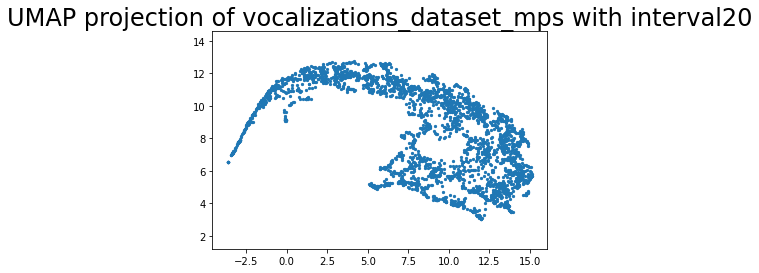

In [160]:
voc_data_mps = collect_data_mps(mat_objs, 20)
print(voc_data_mps.shape)
reducer_mps1 = umap.UMAP()
reducer_mps1.fit(voc_data_mps)
embedding_mps1 = reducer_mps1.transform(voc_data_mps)
assert(np.all(embedding_mps1 == reducer_mps1.embedding_))
print(embedding_mps1.shape)
# import matplotlib.pyplot as plt
plt.figure()
plt.scatter(embedding_mps1[:, 0], embedding_mps1[:, 1], s=5)
plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of vocalizations_dataset_mps with interval' + str(20), fontsize=24);
plt.show()

In [23]:
reducer = umap.UMAP()
reducer_mps.fit(voc_data_mps)
embedding_mps = reducer_mps.transform(voc_data_mps)
assert(np.all(embedding_mps == reducer_mps.embedding_))
print(embedding_mps.shape)

In [117]:
reducer.fit(voc_data)
print(min_time)
embedding = reducer.transform(voc_data)
assert(np.all(embedding == reducer.embedding_))
print(embedding.shape)

23
(2898, 2)


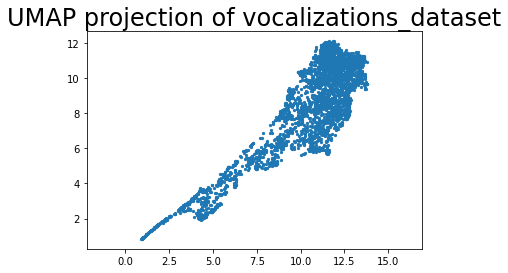

In [118]:
import matplotlib.pyplot as plt
plt.scatter(embedding[:, 0], embedding[:, 1], s=5)
plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of vocalizations_dataset', fontsize=24);